In [51]:
#from tensorflow import keras
#import tensorflow as tf
import pandas as pd
#from scipy import ndimage, misc
#import tensorflow as tf
import os
#from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras import backend as K
#from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.callbacks import CSVLogger
#from tensorflow.keras import regularizers
#from tensorflow.keras.optimizers import RMSprop
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers import SGD
#from os import listdir
from os.path import isfile, join
import gc
from astropy.io import fits
import matplotlib.pyplot as plt
import random
from numpy.random import default_rng
import numpy as np
#from tensorflow.keras import datasets, layers, models
rng = default_rng(42)
import glob
import seaborn as sns
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
#from mlxtend.plotting import plot_confusion_matrix

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [52]:
#tf.config.list_physical_devices('GPU')


In [53]:
def abrir_fits(ruta):
    hdu_list = fits.open(ruta,memmap=False)
    image_data = hdu_list[0].data
    hdu_list.close()
    return image_data

In [133]:
carpetas = ['fits_inclinated','zvar',"z_cero"]
path = '/home/nicolas/nico/Data/SAD_CNN/' + carpetas[2] 

In [104]:
train = pd.concat([pd.DataFrame(glob.glob(f"{path}/all_fits/data_augmentation/0/*"),columns=["direccion"]),pd.DataFrame(glob.glob(f"{path}/all_fits/data_augmentation/1/*"),columns=["direccion"])])

In [114]:
train["SB"] = train["direccion"].str.split("/").str[10].str.split("_").str[-2].str[2:4]

In [116]:
train["label"] = train["direccion"].str.split("/").str[-2]

<Axes: xlabel='SB', ylabel='Count'>

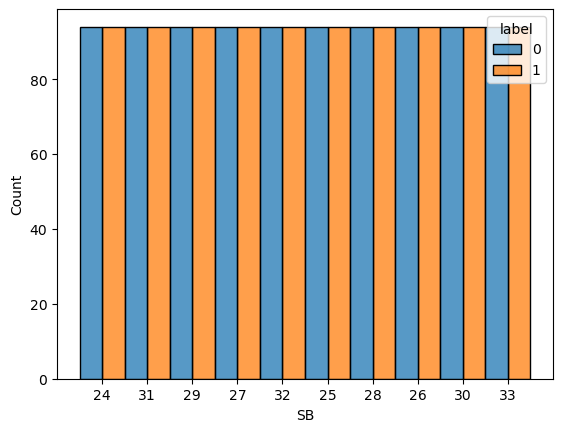

In [118]:
sns.histplot(data=train,x="SB",hue="label", multiple="dodge")

In [119]:
val = pd.read_csv(f"/home/nicolas/nico/git/SAD_CNN/labels/{carpetas[2]}/val.csv")
test = pd.read_csv(f"/home/nicolas/nico/git/SAD_CNN/labels/{carpetas[2]}/test.csv")

In [124]:
val["direccion"] = path +  "/all_fits/" +  val["AU"]+".fits"
test["direccion"] = path+  "/all_fits/" + test["AU"]+".fits"

In [125]:
train["image"] = train.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)
test["image"] = test.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)
val["image"] = val.parallel_apply(lambda row : abrir_fits(row["direccion"]), axis=1)

In [126]:
train["label"] = train.label.astype("int")
val["label"] = val.label.astype("int")
test["label"] = test.label.astype("int")

In [36]:
#tf.random.set_seed(42)

In [127]:
x_train = np.empty((len(train),300, 300,3))
x_val = np.empty((len(val),300,300,3))
x_test = np.empty((len(test),300,300,3))

for i,ima in enumerate(train["image"]):
    img2 = np.zeros( ( np.array(ima).shape[0], np.array(ima).shape[1], 3 ) )
    img2[:,:,0] = ima # same value in each channel
    img2[:,:,1] = ima
    img2[:,:,2] = ima
    x_train[i] = img2

for i,ima in enumerate(val["image"]):
    img2 = np.zeros( ( np.array(ima).shape[0], np.array(ima).shape[1], 3 ) )
    img2[:,:,0] = ima # same value in each channel
    img2[:,:,1] = ima
    img2[:,:,2] = ima
    x_val[i] = img2
    
for i,ima in enumerate(test["image"]):
    img2 = np.zeros( ( np.array(ima).shape[0], np.array(ima).shape[1], 3 ) )
    img2[:,:,0] = ima # same value in each channel
    img2[:,:,1] = ima
    img2[:,:,2] = ima
    x_test[i] = img2



In [137]:
import h5py
with h5py.File(path +"/"+carpetas[2]+"_dataset.h5", 'w') as hdf:
    # Guardar set de entrenamiento
    hdf.create_dataset('x_train', data=x_train)
    hdf.create_dataset('train_labels', data=train.label)
    
    # Guardar set de validación
    hdf.create_dataset('x_val', data=x_val)
    hdf.create_dataset('val_labels', data=val.label)
    
    # Guardar set de testeo
    hdf.create_dataset('x_test', data=x_test)
    hdf.create_dataset('test_labels', data=test.label)